# Neural Network for the KS mapping

## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
import argparse

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from math import sqrt
from KRR_reproduce import *

Using TensorFlow backend.


## Parameters

In [2]:
SEED = 42
EPOCHS = 50000          # maximum number of training epochs
TEST_SIZE = 0.1         # train-test split
OPTIMIZER = 'sgd'
LEARNING_RATE = 0.001   # larger means faster learning, more aggressive, set this in [0.001 - 0.003]
GRID_SPACE = 0.8        # 0.8 instead of 0.08 in the paper -- makes it faster and the input much smaller
DECAY = 0.0             # decay learning rate as training advances
SIM_NO = 150

if GRID_SPACE == 0.08: 
    HIDDEN = (10,)
    # NOT RUN YET, THIS IS VERY EXPENSIVE TO OPTIMIZE
else: 
    HIDDEN = (50,)          # found through hyperparameter optimization
    
# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'

# ignore tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load data

In [3]:
# load data
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # put results in a nicer format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

## Network functions

In [4]:
def init_architecture(input_shape, hidden_size, summary, activation='relu'):
    """
    Built Neural Network using Keras

    :param input_shape: shape of the input data
    :param hidden_size: tuple of number of hidden layers, eg. (30, 30, 40) builds a network with hidden layers 30-30-40
    :param summary: boolean, true plots a summary
    :param activation: activiation function
    :return: keras Sequential model
    """
    model = Sequential()
    print(input_shape)

    # hidden layers
    model.add(Dense(hidden_size[0], input_shape=input_shape, activation=activation))
    for layer_size in hidden_size[1:]:
        model.add(Dense(layer_size, activation=activation))
        model.add(Dropout(0.2))

    # output layer
    model.add(Dense(1, activation='linear'))

    if summary:
        model.summary()

    return model

In [5]:
def train(model, training_data, training_labels, validation_data, validation_labels, batchsize=64):
    """"
    Train Neural Network model
    """
    history = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels),
                        batch_size=batchsize,
                        verbose=0, shuffle=True)
    return history

## Create Gaussian Potentials

In [6]:
pots = []
grid_len = 5.29177 * 2

for n in range(SIM_NO):
    dist = seps[n]
    pot = pot_rep(dist, grid_len, grid_space=GRID_SPACE)
    pot = pot.flatten()
    pots.append(pot)

## Setup training and test data

In [7]:
data = pots
labels = ens
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SIZE, random_state=SEED)

# keras input needs numpy ndarrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Build model and train

In [8]:
# build neural net
model = init_architecture(input_shape=pots[0].shape, hidden_size=tuple(HIDDEN), summary=True,
                          activation='tanh')

# pick optimizer
adam = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

if OPTIMIZER == 'adam': 
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
elif OPTIMIZER == 'sgd': 
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
else: 
    "Default optimizer ADAM being used..."
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
    
# Early stopping on validation error
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=500,
                   verbose=10, mode='auto')

# Log graph and gradients
tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=1, write_graph=True, write_grads=True,
                 write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Save training history
history = model.fit(x_train, y_train, epochs=EPOCHS, verbose=0, validation_split=0.2, callbacks=[es, tb])

(2744,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                137250    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 137,301
Trainable params: 137,301
Non-trainable params: 0
_________________________________________________________________


## Results

15/15 [==============================] - 0s 180us/step

MSE on training data: 	0.004438291177045602
MSE on test data: 		0.008102300337329291

		Pred 	| 	True

[[-31.04011917 -31.12002121]
 [-31.2027626  -31.35579816]
 [-29.73114777 -29.74172427]
 [-30.89792252 -30.97719376]
 [-30.95465469 -31.03509757]
 [-31.67257309 -31.71298488]
 [-31.29566193 -31.35711097]
 [-29.00809479 -29.06048683]
 [-31.18281937 -31.25555287]
 [-30.78507614 -30.85878473]
 [-29.97899628 -29.98936226]
 [-30.84745407 -31.00192919]
 [-31.73731995 -31.74565502]
 [-30.64344788 -30.7632198 ]
 [-31.25415802 -31.40113248]]


Test Loss: 0.008102304302155972
dict_keys(['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss'])


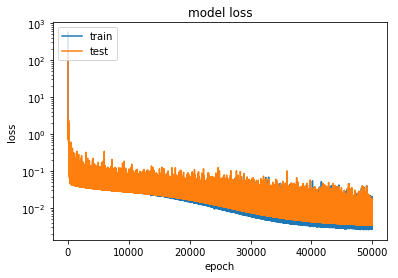

In [9]:
# Predict
test_loss = model.evaluate(x_test, y_test)

# Eval on training data
y_true, y_pred = y_train, model.predict(x_train)
print("\nMSE on training data: \t{}".format(mean_squared_error(y_true, y_pred)))

# Eval on test data
y_true, y_pred = y_test, model.predict(x_test)
print("MSE on test data: \t\t{}".format(mean_squared_error(y_true, y_pred)))

# Predict on new data
print("\n\t\tPred \t| \tTrue\n")
print(np.c_[y_pred, y_true])

# Results
print("\n\nTest Loss: {}".format(test_loss[1]))

# Plot loss history
print(history.history.keys())
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 [1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)